Here we test how closely PyTorchDIA can recover the exact solution when known transformations have been applied to an image. Using Section 3.1 of Bramich 2008 as a guide, we explore the following:

(i) The data image is created by shifting the reference image by one pixel in each of the positive x and y spatial directions, without resampling. The corresponding kernel should be the identity kernel (central pixel value of 1 and 0 elsewhere) shifted by one pixel in each of the negative u and v kernel  coordinates.

(ii) The data image  has been  created by convolving the reference image with a gaussian of $\sigma_K$ = 1.5.

(iii) The reference image is shifted by half a pixel in each of the positive x and y spatial directions to create the data image, an operation that requires the resampling of the reference image. We use a bicubic spline resampling method (scipy.ndimage.interpolation.shift)

However, we'll start with a test '0', where no transformation has been applied; we simply difference an image against itself. This is the only test for which we are truly testing the limiting numerical precision of our algorithm. Even if we shift a data image by just a single integer pixel, there is now no longer a one-to-one mapping for pixels at the borders perpendicular to the axis along which the shift was applied.

In [1]:
# imports
import numpy as np
# scipy.ndimage.interpolation.shift # for consistency with pyDANDIA!
from scipy.ndimage.interpolation import shift
# quote for manuscript - e.g. 'we are doing bicubic spline interpolation'
from scipy.signal import convolve2d
from astropy.io import fits
from MakeFakeImage import MakeFake
import time
import matplotlib.pyplot as plt
%matplotlib inline

In the cell below we'll generate a synthetic reference image. This uses the image generation procedure outlined in Section 3.1 of the manuscript, albeit for a single image. Note however that the particular pyDANDIA implementation of this algorithm which we use in this work makes use of zero-padding so as to include all target image pixels into the kernel solution. This is at the expense of having a mathematically correct model image for the these boundary pixels, and so to guard against this systematic, we will generate a large 1000x1000 pixel image. Further, due to reasons motivating test '0' above, the larger image will further mitigate the effects due to lost information at the image borders.

Max flux: 31887.373306543665
Frac for 142x142 image: 0.3336664210470882
Reference properties
Reference size: 142
Number of sources: 26
PSF standard deviation: 2.4014286128198323
Sky level: 734.6740023932911
F_max/F_total: 0.3336664210470882


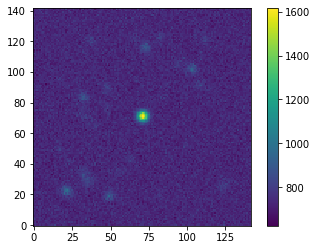

In [2]:
### generate a reference image
np.random.seed(42) # seed for reproducibility

size = 142
log_density = np.random.uniform(0, 3, 1)[0]
#print(log_density)
star_density = 10**log_density # stars per 100x100 pixels
n_sources = np.int(star_density * (size**2/100**2))

reference_psf_sigma = np.random.uniform(0.5, 2.5, 1)[0] # this is ~ [1 - 6] fwhm
sky = np.random.uniform(10, 1000, 1)[0]
# positions
# for convolution in test (ii), phi_I ~ sqrt(2.5**2 + 1.5**2) ~ 3 pixels i.e. 5 standard deviations border = 15 
border = 15 
positions_x = np.random.uniform(border, size-border, (n_sources,1))
positions_y = np.random.uniform(border, size-border, (n_sources,1))
positions = np.hstack((positions_x, positions_y))

# fluxes
F = np.random.uniform(10**(-9), 10**(-4.5), n_sources)
fluxes = F**(-2./3.)
ref_clean, F_frac = MakeFake(N=1, size=size, n_sources=n_sources,
                             psf_sigma=reference_psf_sigma, sky=sky,
                             positions=positions, fluxes=fluxes, shifts=[0., 0.])

print('Reference properties')
print('Reference size:', size)
print('Number of sources:', n_sources)
print('PSF standard deviation:', reference_psf_sigma)
print('Sky level:', sky)
print('F_max/F_total:', F_frac)

# and add some noise
def add_noise_to_image(image, read_noise):
    noise_map = np.random.normal(0, 1, size=image.shape)
    sigma_I = np.sqrt(read_noise**2 + image)
    image += noise_map*sigma_I
    return image, sigma_I

R, sigma_R = add_noise_to_image(ref_clean, read_noise=5)

# and plot
plt.imshow(R, origin='lower')
plt.colorbar();

OK, now let's generate the 3 data images for tests (i)-(iii).
First let's do (i) and (iii)...
I'll inspect the transformations by-eye to make sure all's well.

In [3]:
# save a np.ndarray as .fits
def save_numpy_as_fits(numpy_array, filename):
    hdu = fits.PrimaryHDU(numpy_array)
    hdul = fits.HDUList([hdu])
    hdul.writeto(filename, overwrite=True)

save_numpy_as_fits(R, 'data0.fits')

In [4]:
# load R - the image generation procedure above takes a **long** time for 1kx1k images
R = fits.getdata('data0.fits', dtype=np.float64)
sky = 734.6740023932911
print('Sky level:', sky)

Sky level: 734.6740023932911


In [5]:
# required to deal with edge pixels (convolutions don't like edges!)
def extend_image_hw(image, kernel_size):
    image_extended = np.zeros((np.shape(image)[0] + kernel_size - 1,
                             np.shape(image)[1] + kernel_size - 1))
    hwidth = np.int((kernel_size - 1) / 2)
    image_extended[hwidth:image_extended.shape[0]-hwidth,
                   hwidth:image_extended.shape[1]-hwidth] = np.array(image, float)
    return image_extended

# required to deal with edge pixels (convolutions don't like edges!)
def extend_image_hw_nonzero(image, kernel_size, fill_level):
    image_extended = fill_level * np.ones((np.shape(image)[0] + kernel_size - 1,
                             np.shape(image)[1] + kernel_size - 1))
    hwidth = np.int((kernel_size - 1) / 2)
    image_extended[hwidth:image_extended.shape[0]-hwidth,
                   hwidth:image_extended.shape[1]-hwidth] = np.array(image, float)
    return image_extended


# When shifting we fill values around the border with some level.
# These violate the noise model, and so should be cropped.
def trim_image(image):
    nx, ny = image.shape
    image = image[1:nx, 1:ny]
    return image

In [6]:
# (i) integer shift
int_shift = (1, 1)
data1 = shift(R, int_shift, order=0, cval=sky)
data1 = trim_image(data1)
save_numpy_as_fits(data1, 'data1.fits')

# (iii) sub-pixel shift, bicubic spline resampling
float_shift = (0.5, 0.5)
data3 = shift(R, float_shift, order=3, cval=sky)
data3 = trim_image(data3)
save_numpy_as_fits(data3, 'data3.fits')

...and now define a gaussian kernel to convolve with R for test (ii)

*A note on handling edge pixels in convolutions*

Valid convolutions do not exist for target image pixels within a convolution kernel's half-width from the image edges. We have the choice to (i) just ignore them and work with valid convoltuions only, or (ii) apply some sort of padding to the image(s). In this work, when computing the model image with the inferred kernel and background term, we zero-pad the reference image before convolving with the kernel. (Perhaps?) Importantly, we have inferred the model parameters with a sky-subtracted reference image. In this instance, using zero-padding on this sky-subtracted image is a good choice; we are in effect padding with the new sky level, 0. If however the 'sky' level is not zero in the image to padded, zero-padding does not seem like the best choice. Instead, try using the non-zero sky level.

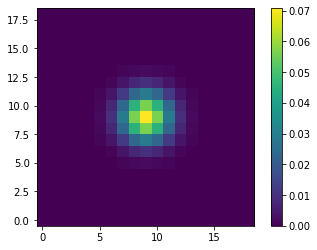

In [7]:
test_kernel_size = 19
nx, ny = (test_kernel_size, test_kernel_size) # kernel object shape
xg, yg = np.meshgrid(range(nx), range(ny))
xc, yc = (np.int(nx/2), np.int(ny/2))
sigma_k = 1.5 # gaussian kernel standard deviation
test_kernel = np.exp(-0.5 * ((xg - xc) ** 2 + (yg - yc) ** 2) / sigma_k ** 2)
test_kernel /= np.sum(test_kernel) # normalise to 1

# and plot
plt.imshow(test_kernel, origin='lower')
plt.colorbar();

# and convolve with the extended reference
#R_ext = extend_image_hw(R, test_kernel_size)
R_ext = extend_image_hw_nonzero(R, test_kernel_size, fill_level=sky)
data2_ext = convolve2d(R_ext, test_kernel, mode='same')
save_numpy_as_fits(data2_ext, 'data2_ext.fits')

# and trim back to the correct size
hwidth = np.int((test_kernel_size - 1) / 2)
data2 = data2_ext[hwidth:data2_ext.shape[0]-hwidth, hwidth:data2_ext.shape[1]-hwidth]
save_numpy_as_fits(data2, 'data2.fits')

Great, now let's run PyTorchDIA and pyDANDIA (B08) on the 3 image pairs. We'll need to first need to setup the Cythonized B08 solution.

In [8]:
%load_ext Cython

In [9]:
%%cython

from __future__ import division
import numpy as np
cimport numpy as np
cimport cython
DTYPE = np.float64
ctypedef np.float64_t DTYPE_t

# compile suggestion: gcc -shared -pthread -fPIC -fwrapv -O2 -Wall -fno-strict-aliasing -I/somepath/include/python2.7 -o umatrix_routine.so umatrix_routine.c

@cython.boundscheck(False) # turn off bounds-checking
@cython.wraparound(False)  # turn off negative index wrapping
@cython.nonecheck(False)  # turn off negative index wrapping

def umatrix_construction(np.ndarray[DTYPE_t, ndim = 2] reference_image,np.ndarray[DTYPE_t, ndim = 2] weights, pandq, n_kernel_np, kernel_size_np):

    cdef int ni_image = np.shape(reference_image)[0]
    cdef int nj_image = np.shape(reference_image)[1]
    cdef double sum_acc = 0.
    cdef int idx_l,idx_m,idx_l_prime,idx_m_prime,idx_i,idx_j
    cdef int kernel_size = np.int(kernel_size_np)
    cdef int kernel_size_half = np.int(kernel_size_np)/2
    cdef int n_kernel = np.int(n_kernel_np)
    cdef np.ndarray u_matrix = np.zeros([n_kernel + 1, n_kernel + 1], dtype=DTYPE)

    for idx_p in range(n_kernel):
        for idx_q in range(idx_p,n_kernel):
            sum_acc = 0.
            idx_l, idx_m = pandq[idx_p]
            idx_l_prime, idx_m_prime = pandq[idx_q]
            for idx_i in range(kernel_size_half,ni_image-kernel_size+kernel_size_half+1):
                for idx_j in range(kernel_size_half,nj_image-kernel_size+kernel_size_half+1):
                    sum_acc += reference_image[idx_i + idx_l, idx_j + idx_m] * reference_image[idx_i + idx_l_prime,idx_j + idx_m_prime]  * weights[idx_i, idx_j]
            u_matrix[idx_p, idx_q] = sum_acc
            u_matrix[idx_q, idx_p] = sum_acc

    for idx_p in [n_kernel]:
        for idx_q in range(n_kernel):
            sum_acc = 0.
            idx_l = kernel_size
            idx_m = kernel_size
            idx_l_prime, idx_m_prime = pandq[idx_q]
            for idx_i in range(kernel_size_half,ni_image-kernel_size+kernel_size_half+1):
                for idx_j in range(kernel_size_half,nj_image-kernel_size+kernel_size_half+1):
                    sum_acc += reference_image[idx_i + idx_l_prime, idx_j + idx_m_prime] * weights[idx_i, idx_j]
            u_matrix[idx_p, idx_q] = sum_acc
    
    for idx_p in range(n_kernel):
        for idx_q in [n_kernel]:
            sum_acc = 0.
            idx_l, idx_m = pandq[idx_p]
            idx_l_prime = kernel_size
            idl_m_prime = kernel_size
            for idx_i in range(kernel_size_half,ni_image-kernel_size+kernel_size_half+1):
                for idx_j in range(kernel_size_half, nj_image-kernel_size+kernel_size_half+1):
                    sum_acc += reference_image[idx_i + idx_l, idx_j + idx_m] * weights[idx_i, idx_j] 
            u_matrix[idx_p, idx_q] = sum_acc

    sum_acc = 0.
    for idx_i in range(ni_image):
        for idx_j in range(nj_image):
            sum_acc += weights[idx_i, idx_j] 
    u_matrix[n_kernel, n_kernel] = sum_acc
    
    return u_matrix

def bvector_construction(np.ndarray[DTYPE_t, ndim = 2] reference_image,np.ndarray[DTYPE_t, ndim = 2] data_image,np.ndarray[DTYPE_t, ndim = 2] weights, pandq, n_kernel_np, kernel_size_np):

    cdef int ni_image = np.shape(data_image)[0]
    cdef int nj_image = np.shape(data_image)[1]
    cdef double sum_acc = 0.
    cdef int idx_l,idx_m,idx_l_prime,idx_m_prime,idx_i,idx_j
    cdef int kernel_size = np.int(kernel_size_np)
    cdef int kernel_size_half = np.int(kernel_size_np)/2
    cdef int n_kernel = np.int(n_kernel_np)
        
    cdef np.ndarray b_vector = np.zeros([n_kernel + 1], dtype=DTYPE)
    for idx_p in range(n_kernel):
        idx_l, idx_m = pandq[idx_p]
        sum_acc = 0.
        for idx_i in range(kernel_size_half,ni_image-kernel_size+kernel_size_half+1):
            for idx_j in range(kernel_size_half,nj_image-kernel_size+kernel_size_half+1):
                   sum_acc += data_image[idx_i, idx_j] * reference_image[idx_i + idx_l , idx_j + idx_m ] * weights[idx_i, idx_j]
        b_vector[idx_p] = sum_acc

    sum_acc = 0.
    for idx_i in range(ni_image):
        for idx_j in range(nj_image):
            sum_acc += data_image[idx_i, idx_j] * weights[idx_i, idx_j]
    b_vector[n_kernel] = sum_acc

    return b_vector

In [10]:
import PyTorchDIA_noiseless
import torch
torch.backends.cudnn.deterministic = True # ensure PyTorchDIA solution is reproducible

PyTorch version: 1.6.0


In [11]:
## Importantly, we'll subtract the known (scalar) sky level from the reference frame.
## This breaks the degeneracy between the photometric scale factor and the 
## differential background.

R0 = np.copy(R) # for test '0'

print('Sky level:', sky)
R -= sky

# and reshape R for tests (i) and (iii)
R1, R3 = trim_image(R), trim_image(R)
R2 = np.copy(R)

Sky level: 734.6740023932911


The B08 algorithm shoud be able to return the exact kernel solution, to within machine precision, given that this approach is analytical. Let's define some functions to run the required operations for this algorithm.

In [12]:
# define function to return the model image, and appropriately guard-against edge effects
def model_image(R, kernel, B0):
    model = convolve2d(R, kernel, mode='same') + B0
    return model

def crop_model_image(ext_M, kernel_size):
    hwidth = np.int((kernel_size - 1) / 2)
    M = ext_M[hwidth:ext_M.shape[0]-hwidth, hwidth:ext_M.shape[1]-hwidth]
    return M

# function to build the kernel, U matrix and b vector
def construct_kernel_and_matrices(kernel_size, R, I, weights):

    pandq = []
    n_kernel = kernel_size * kernel_size
    ncount = 0
    half_kernel_size = int(int(kernel_size) / 2)
    for lidx in range(kernel_size):
        for midx in range(kernel_size):
            pandq.append((lidx - half_kernel_size, midx - half_kernel_size))


    R = R.astype('float64')
    I =  I.astype('float64')
    weights = weights.astype('float64')

    start_time = time.time()
    U = umatrix_construction(R, weights, pandq, n_kernel, kernel_size)
    b = bvector_construction(R, I, weights, pandq, n_kernel, kernel_size)
    print("--- Finished U and b construction in %s seconds ---" % (time.time() - start_time))
    return U, b


# define a function for the least-squares solution
def lstsq_solution(R, I, U, b, kernel_size):
    
    lstsq_result = np.linalg.lstsq(np.array(U), np.array(b), rcond=None)
    a_vector = lstsq_result[0]
    lstsq_fit = np.dot(np.array(U), a_vector)
    resid = np.array(b) - lstsq_fit
    reduced_chisqr = np.sum(resid ** 2) / (float(kernel_size * kernel_size))
    lstsq_cov = np.dot(np.array(U).T, np.array(U)) * reduced_chisqr
    resivar = np.var(resid, ddof=0) * float(len(a_vector))
    
    # use pinv in order to stabilize calculation
    a_var = np.diag(np.linalg.pinv(lstsq_cov) * resivar)

    a_vector_err = np.sqrt(a_var)
    output_kernel = np.zeros(kernel_size * kernel_size, dtype=float)
    if len(a_vector) > kernel_size * kernel_size:
        output_kernel = a_vector[:-1]
    else:
        output_kernel = a_vector
    output_kernel = output_kernel.reshape((kernel_size, kernel_size))

    err_kernel = np.zeros(kernel_size * kernel_size, dtype=float)
    if len(a_vector) > kernel_size * kernel_size:
        err_kernel = a_vector_err[:-1]
        err_kernel = err_kernel.reshape((kernel_size, kernel_size))
    else:
        err_kernel = a_vector_err
        err_kernel = err_kernel.reshape((kernel_size, kernel_size))

    output_kernel_2 = np.flip(np.flip(output_kernel, 0), 1)
    err_kernel_2 = np.flip(np.flip(err_kernel, 0), 1)
    bkg_kernel = a_vector[-1]
    output_kernel_2.shape

    return output_kernel_2, bkg_kernel

def B08(R, I, flat, ks, sigma_0, n_iters):
    
    for i in range(0, n_iters):

        
        if i == 0:

            # for first pass, estimate weights with inverse variance map
            w = 1./(I + sigma_0**2)
        else:
            # replace I with current estimate of the model, M
            w = 1./(M + sigma_0**2)
        
        #w = np.ones(I.shape)
        
        if i < n_iters:

            print('\npyDANDIA solution, iter %d' % i)
            ext_R = extend_image_hw(R, ks)
            ext_I = extend_image_hw(I, ks)
            ext_w = extend_image_hw(w, ks)

            U, b = construct_kernel_and_matrices(ks, ext_R, ext_I, ext_w)
            kernel, B0 = lstsq_solution(ext_R, ext_I, U, b, ks)
            
            print('P, B0:', np.sum(kernel), B0)
            
            ext_M = model_image(ext_R, kernel, B0)
            M = crop_model_image(ext_M, ks)
           
    return kernel, B0, M     

In [13]:
## check all image pairs have the correct shapes
print(R1.shape, data1.shape)
print(R2.shape, data2.shape)
print(R3.shape, data3.shape)

(141, 141) (141, 141)
(142, 142) (142, 142)
(141, 141) (141, 141)


In [14]:
# ...and the precision of the input data
# important for ascertaining numerical rounding errors
# F32: 6-9 decimal digit precision
# F64: 15-17 decimal digit precision
print(R1.dtype, data1.dtype)
print(R2.dtype, data2.dtype)
print(R3.dtype, data3.dtype)

>f8 float64
>f8 float64
>f8 float64


## Test 0
Before moving on to tests (i)-(iii), let's do the test 0. Differencing R against itself. We should recover a kernel with a centre pixel of exactly 1 and zeros everywhere else.

In [15]:
kernel_b08_0, B0_b08_0, M_b08_0 = B08(R0 - sky, R0, np.ones(R0.shape), 19, 5, 3)


pyDANDIA solution, iter 0
--- Finished U and b construction in 1.8366146087646484 seconds ---
P, B0: 0.9999999999997995 734.6740023932939

pyDANDIA solution, iter 1
--- Finished U and b construction in 1.8240406513214111 seconds ---
P, B0: 1.0000000000000044 734.6740023932912

pyDANDIA solution, iter 2
--- Finished U and b construction in 1.7923123836517334 seconds ---
P, B0: 0.9999999999999708 734.6740023932913


Photometric scale factor: 0.9999999999999708
Peak value of kernel: 0.9999999999999828
Differential Background: 734.6740023932913
Squared-sum of Difference image: 1.5824953275853994e-17


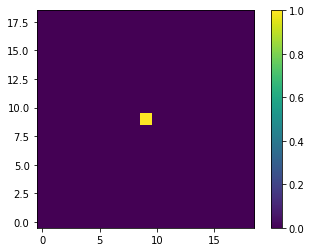

In [16]:
D_b08_0 = R0 - M_b08_0
plt.imshow(kernel_b08_0, origin='lower')
plt.colorbar();
print('Photometric scale factor:', np.sum(kernel_b08_0))
print('Peak value of kernel:', np.max(kernel_b08_0))
print('Differential Background:', B0_b08_0)
print('Squared-sum of Difference image:', np.sum(D_b08_0**2))

--- Time to move data onto GPU: 1.9219400882720947 ---
Check dtype of data and weights:
torch.float32 torch.float32 torch.float32 torch.float32
Check size of data and weights:
torch.Size([1, 1, 142, 142]) torch.Size([1, 1, 142, 142]) torch.Size([1, 1, 19, 19]) torch.Size([1])
Starting optimisation
Switching to Quasi-Newton step after 172 SD steps
Converged!
Total steps taken: 180
SD steps: 172
L-BFGS steps: 8
--- Finished kernel and background fit in 1.0341072082519531 seconds ---
Photometric scaling: tensor(0.9999999404, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 734.6740112304688


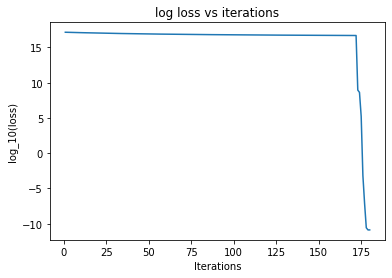

--- Finished in a total of 3.093271493911743 seconds ---


In [17]:
# and now for PyTorchDIA


###################
### N.B. KENREL SIZE = 3X3
##################
kernel_pt_0, B0_pt_0 = PyTorchDIA_noiseless.DIA(R0 - sky,
                           R0,
                           np.ones(R0.shape), # flatfield
                           rdnoise = 5,
                           G = 1,
                           ks = 19,
                           lr_kernel = 1e-4,
                           lr_B = 1,
                           max_iterations = 25000,
                           poly_degree=0,
                           alpha = 0.,
                           Newton_tol = 1e-3,
                           tol = 1e-9,
                           fast=True,
                           fisher=False,
                           show_convergence_plots=True)

ext_R0 = extend_image_hw(R0 - sky, kernel_size=19)
ext_M_pt_0 = model_image(ext_R0, kernel_pt_0, B0_pt_0)
M_pt_0 = crop_model_image(ext_M_pt_0, kernel_size=19)

Photometric scale factor: 0.99999976
Peak value of kernel: 1.0000001
Photometric scale factor eror: -2.384185791015625e-07
Differential Background: 734.6740112304688
Differential Background err: 8.837177688292286e-06
epsilon B0: 1.2028706146541311e-08
Squared-sum of Difference image: 7.4975244382163565e-06


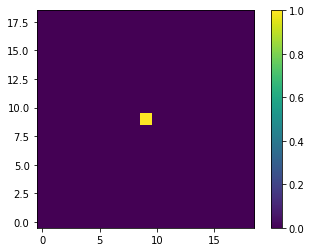

In [33]:
D_pt_0 = R0 - M_pt_0
plt.imshow(kernel_pt_0, origin='lower')
plt.colorbar();
print('Photometric scale factor:', np.sum(kernel_pt_0))
print('Peak value of kernel:', np.max(kernel_pt_0))
print('Photometric scale factor eror:', np.sum(kernel_pt_0) - 1)
print('Differential Background:', B0_pt_0)
print('Differential Background err:', B0_pt_0 - sky)
print('epsilon B0:', (B0_pt_0 - sky)/sky)
print('Squared-sum of Difference image:', np.sum(D_pt_0**2))

In [49]:
print(np.sum(D_b08_0**2) / np.sum(D_pt_0**2))

2.1106904560645502e-12


**Test '0' discussion**

As expected, the B08 algorithm does an excellent job and returns the correct kernel to within numerical rounding errors. Unfortunately, the picture is less clean for PyTorchDIA. Ideally, we would hope the precision would be at the convergence tolerance of the data precision. PyTorchDIA uses F32 by default, giving 6-9 decimal digits of precision, yet the peak kernel pixel is only accurate to 4 digits. But does this 'algorithmic' systematic source of uncertainty matter in practice?

The large difference in the squared-sum of the difference image between the two approaches is refletive of the underestimation of the sky level in the target image by ~0.54 ADU. This systematic non-zero offset in the difference image is in fact trivial to correct for if measuring difference fluxes by PSF fitting photometry; one just has to include an additional background paramter in the fit. In this example, as far as photometroc accuracy is concerned, the most important 'parameter' is the photometric scale factor, $P$. We see that PyTorchDIA has slightly overestimated $P$, with a fractional systematic uncertainty of ~0.04 %. Fortunately, this is however below typical photometric precision -- which is usually in the range of 0.1 - 5 % -- and so would only pose a problem where the stochastic noise component of the photometry is at ~0.01 % or better. Given that $B_0$ here is underestimated, it is not surprising that $P$ is consequently somewhat oversestimated; these quantities are strongly anticorrelated.

## Test (i)

In [42]:
# OK, let's run B08 on the image pair for test (i)
kernel_b08_1, B0_b08_1, M_b08_1 = B08(R1, data1, np.ones(data1.shape), 19, 5, 3)


pyDANDIA solution, iter 0
--- Finished U and b construction in 1.7759487628936768 seconds ---
P, B0: 1.000683889943145 734.6698599805786

pyDANDIA solution, iter 1
--- Finished U and b construction in 1.81532621383667 seconds ---
P, B0: 0.9999694664019126 734.6874679776139

pyDANDIA solution, iter 2
--- Finished U and b construction in 1.8615705966949463 seconds ---
P, B0: 0.9999694455029677 734.6874680792594


Photometric scale factor: 0.9999694455029677
epsilon P: -3.055449703226465e-05
Peak value of kernel: 1.0001794376003499
Differential Background: 734.6874680792594
epsilon B_0: 1.8328790626091277e-05
Squared-sum of Difference image: 215616.91487189036


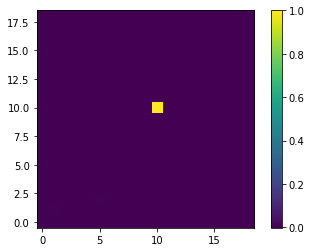

In [43]:
D_b08_1 = data1 - M_b08_1
plt.imshow(kernel_b08_1, origin='lower')
plt.colorbar();
print('Photometric scale factor:', np.sum(kernel_b08_1))
print('epsilon P:', np.sum(kernel_b08_1) - 1)
print('Peak value of kernel:', np.max(kernel_b08_1))
print('Differential Background:', B0_b08_1)
print('epsilon B_0:', (B0_b08_1 - sky) / sky)
print('Squared-sum of Difference image:', np.sum(D_b08_1**2))

--- Time to move data onto GPU: 0.00024056434631347656 ---
Check dtype of data and weights:
torch.float32 torch.float32 torch.float32 torch.float32
Check size of data and weights:
torch.Size([1, 1, 141, 141]) torch.Size([1, 1, 141, 141]) torch.Size([1, 1, 19, 19]) torch.Size([1])
Starting optimisation
Switching to Quasi-Newton step after 172 SD steps
Converged!
Total steps taken: 178
SD steps: 172
L-BFGS steps: 6
--- Finished kernel and background fit in 0.7349863052368164 seconds ---
Photometric scaling: tensor(0.9999781847, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 734.6876220703125


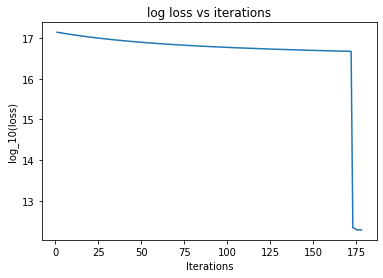

--- Finished in a total of 0.8660581111907959 seconds ---


In [21]:
# and now for PyTorchDIA
kernel_pt_1, B0_pt_1 = PyTorchDIA_noiseless.DIA(R1,
                           data1,
                           np.ones(data1.shape), # flatfield
                           rdnoise = 5,
                           G = 1,
                           ks = 19,
                           lr_kernel = 1e-4,
                           lr_B = 1e-1,
                           max_iterations = 25000,
                           poly_degree=0,
                           alpha = 0.,
                           Newton_tol = 1e-3,
                           tol = 1e-9,
                           fast=True,
                           fisher=False,
                           show_convergence_plots=True)

ext_R1 = extend_image_hw(R1, kernel_size=19)
ext_M_pt_1 = model_image(ext_R1, kernel_pt_1, B0_pt_1)
M_pt_1 = crop_model_image(ext_M_pt_1, kernel_size=19)

Photometric scale factor: 0.99997824
Photometric scale factor error: -2.1755695343017578e-05
Peak value of kernel: 1.0001688
Differential Background: 734.6876220703125
Differential Background error: 0.013619677021438292
epsilon B0: 1.853839522981692e-05
Squared-sum of Difference image: 215616.66512773905


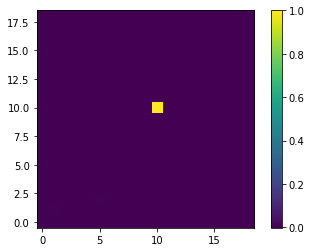

In [37]:
D_pt_1 = data1 - M_pt_1
plt.imshow(kernel_pt_1, origin='lower')
plt.colorbar();
print('Photometric scale factor:', np.sum(kernel_pt_1))
print('Photometric scale factor error:', np.sum(kernel_pt_1) - 1)
print('Peak value of kernel:', np.max(kernel_pt_1))
print('Differential Background:', B0_pt_1)
print('Differential Background error:', B0_pt_1 - sky)
print('epsilon B0:', (B0_pt_1 - sky)/sky)
print('Squared-sum of Difference image:', np.sum(D_pt_1**2))

In [50]:
print(np.sum(D_b08_1**2) / np.sum(D_pt_1**2))

1.0000011582785178


**Test (i) discussion**

Both tests do fairly well here, with B08 unsurprisingly performing the best. It's the underestimation of $B_0$ by PyTorchDIA that really separates them. Both approaches overestimate $P$, and B08 does better by an order of magnitude, although happily, this fractional uncertainty in $P$ is still lower than typical stochastic photometric noise.

## Test (ii)

In [23]:
# OK, let's run B08 on test (ii)
kernel_b08_2, B0_b08_2, M_b08_2 = B08(R2, data2, np.ones(data2.shape), 19, 5, 3)


pyDANDIA solution, iter 0
--- Finished U and b construction in 1.9110682010650635 seconds ---
P, B0: 1.0000000000001736 734.6740023932875

pyDANDIA solution, iter 1
--- Finished U and b construction in 1.8193728923797607 seconds ---
P, B0: 1.0000000000002451 734.6740023932884

pyDANDIA solution, iter 2
--- Finished U and b construction in 1.8943424224853516 seconds ---
P, B0: 1.000000000000252 734.6740023932865


Photometric scale factor: 1.000000000000252
Peak value of kernel: 0.07073553027998668
Differential Background: 734.6740023932865
Squared-sum of Difference image: 1.88925861041711e-17


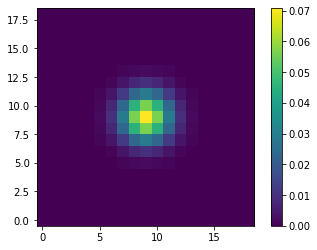

In [24]:
D_b08_2 = data2 - M_b08_2
plt.imshow(kernel_b08_2, origin='lower')
plt.colorbar();
print('Photometric scale factor:', np.sum(kernel_b08_2))
print('Peak value of kernel:', np.max(kernel_b08_2))
print('Differential Background:', B0_b08_2)
print('Squared-sum of Difference image:', np.sum(D_b08_2**2))

--- Time to move data onto GPU: 0.0002295970916748047 ---
Check dtype of data and weights:
torch.float32 torch.float32 torch.float32 torch.float32
Check size of data and weights:
torch.Size([1, 1, 142, 142]) torch.Size([1, 1, 142, 142]) torch.Size([1, 1, 19, 19]) torch.Size([1])
Starting optimisation
Switching to Quasi-Newton step after 4345 SD steps
Converged!
Total steps taken: 4348
SD steps: 4345
L-BFGS steps: 3
--- Finished kernel and background fit in 7.923452854156494 seconds ---
Photometric scaling: tensor(0.9999996424, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 734.6740112304688


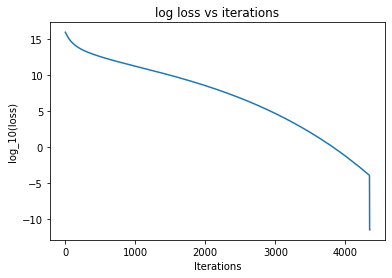

--- Finished in a total of 8.125977993011475 seconds ---


In [25]:
# test (ii)
kernel_pt_2, B0_pt_2 = PyTorchDIA_noiseless.DIA(R2,
                           data2,
                           np.ones(data2.shape), # flatfield
                           rdnoise = 5,
                           G = 1,
                           ks = 19,
                           lr_kernel = 1e-4,
                           lr_B = 1e-1,
                           max_iterations = 25000,
                           poly_degree=0,
                           alpha = 0.,
                           Newton_tol = 1e-3,
                           tol = 1e-9,
                           fast=True,
                           fisher=False,
                           show_convergence_plots=True)

ext_R2 = extend_image_hw(R2, kernel_size=19)
ext_M_pt_2 = model_image(ext_R2, kernel_pt_2, B0_pt_2)
M_pt_2 = crop_model_image(ext_M_pt_2, kernel_size=19)

Photometric scale factor: 0.99999964
Photometric scale factor error: -3.5762786865234375e-07
Peak value of kernel: 0.070735574
Differential Background: 734.6740112304688
Differential Background error: 8.837177688292286e-06
epsilon B0: 1.2028706146541311e-08
Squared-sum of Difference image: 1.7007436116877634e-06


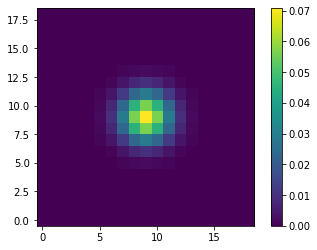

In [34]:
D_pt_2 = data2 - M_pt_2
plt.imshow(kernel_pt_2, origin='lower')
plt.colorbar();
print('Photometric scale factor:', np.sum(kernel_pt_2))
print('Photometric scale factor error:', np.sum(kernel_pt_2) - 1)
print('Peak value of kernel:', np.max(kernel_pt_2))
print('Differential Background:', B0_pt_2)
print('Differential Background error:', B0_pt_2 - sky)
print('epsilon B0:', (B0_pt_2 - sky)/sky)
print('Squared-sum of Difference image:', np.sum(D_pt_2**2))

In [54]:
print(np.sum(D_b08_2**2)/np.sum(D_pt_2**2))

1.1108426910639813e-11


**Test (ii) discussion**

Much the same story here again. B08 once again returns teh correct result to within machine precision, while PyTorchDIA slightly underestimates $B_0$. Although $P$ is also (perhaps consequently) overestimated, this fractional systematic offset is less than typical photometric precision.

In [47]:
# OK, let's run B08 on test (iii)
kernel_b08_3, B0_b08_3, M_b08_3 = B08(R3, data3, np.ones(data3.shape), 19, 5, 1)


pyDANDIA solution, iter 0
--- Finished U and b construction in 1.9264352321624756 seconds ---
P, B0: 1.000095889476583 734.6747498546781


Photometric scale factor: 1.000095889476583
epsilon P: 9.588947658301095e-05
Peak value of kernel: 0.3609425864234235
Differential Background: 734.6747498546781
epsilon B_0: 1.0174055221976072e-06
Squared-sum of Difference image: 65084.6237638289


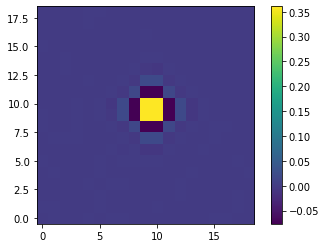

In [48]:
D_b08_3 = data3 - M_b08_3
plt.imshow(kernel_b08_3, origin='lower')
plt.colorbar();
print('Photometric scale factor:', np.sum(kernel_b08_3))
print('epsilon P:', np.sum(kernel_b08_3) - 1)
print('Peak value of kernel:', np.max(kernel_b08_3))
print('Differential Background:', B0_b08_3)
print('epsilon B_0:', (B0_b08_3 - sky)/sky)
print('Squared-sum of Difference image:', np.sum(D_b08_3**2))

--- Time to move data onto GPU: 0.00036144256591796875 ---
Check dtype of data and weights:
torch.float32 torch.float32 torch.float32 torch.float32
Check size of data and weights:
torch.Size([1, 1, 141, 141]) torch.Size([1, 1, 141, 141]) torch.Size([1, 1, 19, 19]) torch.Size([1])
Starting optimisation
Switching to Quasi-Newton step after 254 SD steps
Converged!
Total steps taken: 261
SD steps: 254
L-BFGS steps: 7
--- Finished kernel and background fit in 0.8506121635437012 seconds ---
Photometric scaling: tensor(1.0000119209, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 734.6787719726562


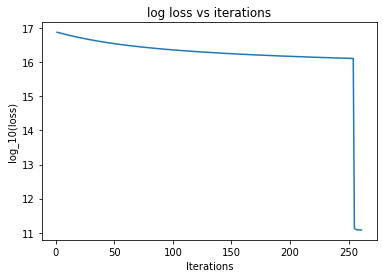

--- Finished in a total of 0.9873287677764893 seconds ---


In [29]:
# test (iii)
kernel_pt_3, B0_pt_3 = PyTorchDIA_noiseless.DIA(R3,
                           data3,
                           np.ones(data3.shape), # flatfield
                           rdnoise = 5,
                           G = 1,
                           ks = 19,
                           lr_kernel = 1e-4,
                           lr_B = 1e-1,
                           max_iterations = 25000,
                           poly_degree=0,
                           alpha = 0.,
                           Newton_tol = 1e-3,
                           tol = 1e-9,
                           fast=True,
                           fisher=False,
                           show_convergence_plots=True)

ext_R3 = extend_image_hw(R3, kernel_size=19)
ext_M_pt_3 = model_image(ext_R3, kernel_pt_3, B0_pt_3)
M_pt_3 = crop_model_image(ext_M_pt_3, kernel_size=19)

Photometric scale factor: 1.0000118
Photometric scale factor error: 1.1801719665527344e-05
Peak value of kernel: 0.36094046
Differential Background: 734.6787719726562
Differential Background error: 0.004769579365188292
epsilon B_0: 6.492103095591786e-06
Squared-sum of Difference image: 65083.08866137202


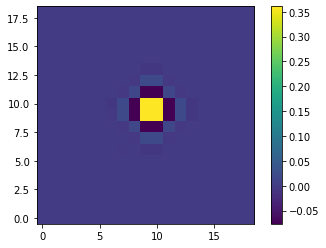

In [46]:
D_pt_3 = data3 - M_pt_3
plt.imshow(kernel_pt_3, origin='lower')
plt.colorbar();
print('Photometric scale factor:', np.sum(kernel_pt_3))
print('Photometric scale factor error:', np.sum(kernel_pt_3) - 1)
print('Peak value of kernel:', np.max(kernel_pt_3))
print('Differential Background:', B0_pt_3)
print('Differential Background error:', B0_pt_3 - sky)
print('epsilon B_0:', (B0_pt_3 - sky)/sky)
print('Squared-sum of Difference image:', np.sum(D_pt_3**2))

**Test (iii) discussion**

Both approaches do OK here, with B08 again being superior. Once again, the fractional uncertainty in $P$ as measured by PyTorchDIA is just below the best end of the range of stochastic noise levels in typical photometry

In [56]:
print(np.sum(D_b08_3**2)/np.sum(D_pt_3**2))

1.00002358681016
